In [1]:
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister, AncillaRegister
from qiskit.visualization import plot_histogram
from matplotlib import pyplot as plt
import numpy as np
import array
import math
import fractions

from QuantumRingsLib import QuantumRingsProvider
from quantumrings.toolkit.qiskit import QrBackendV2

In [2]:
# load API keys
from dotenv import load_dotenv
import os

load_dotenv()
QR_TOKEN = os.getenv("QR_TOKEN")
QR_NAME = os.getenv("QR_NAME")

# Acquire the Quantum Rings Provider
qr_provider = QuantumRingsProvider(token=QR_TOKEN, name=QR_NAME)

In [3]:
def modinv(a, m):
    return pow(a, -1, m)

In [4]:
def getAngles(a,N):
    s=bin(int(a))[2:].zfill(N)
    angles=np.zeros([N])
    for i in range(0, N):
        for j in range(i,N):
            if s[j]=='1':
                angles[N-i-1]+=np.power(2.0, -(j-i))
        angles[N-i-1]*=np.pi
    return angles

"""Creation of a doubly controlled phase gate"""
def ccphase(circuit,angle,ctl1,ctl2,tgt):
    # TODO: check if this is the same
    #circuit.cu1(angle/2,ctl1,tgt)
    circuit.cp(angle/2,ctl1,tgt)
    circuit.cx(ctl2,ctl1)
    #circuit.cu1(-angle/2,ctl1,tgt)
    circuit.cp(-angle/2,ctl1,tgt)
    circuit.cx(ctl2,ctl1)
    #circuit.cu1(angle/2,ctl2,tgt)
    circuit.cp(angle/2,ctl2,tgt)

In [5]:
def create_QFT(circuit : QuantumCircuit, up_reg : QuantumRegister, n, with_swaps):
    i = n - 1
    """ Apply the H gates and Cphases"""
    """ The Cphases with |angle| < threshold are not created because they do
    nothing. The threshold is put as being 0 so all CPhases are created,
    but the clause is there so if wanted just need to change the 0 of the
    if-clause to the desired value """
    while i >= 0:
        circuit.h(up_reg[i])
        j = i - 1
        while j >= 0:
            if (np.pi) / (pow(2, (i - j))) > 0:
                # TODO: check cp cu1
                #circuit.cu1((np.pi) / (pow(2, (i - j))), up_reg[i], up_reg[j])
                circuit.cp((np.pi) / (pow(2, (i - j))), up_reg[i], up_reg[j])
                j = j - 1
        i = i - 1

    """ If specified, apply the Swaps at the end """
    if with_swaps == 1:
        i = 0
        while i < ((n - 1) / 2):
            circuit.swap(up_reg[i], up_reg[n - 1 - i])
            i = i + 1

def create_inverse_QFT(circuit, up_reg, n, with_swaps):
    """If specified, apply the Swaps at the beggining"""
    if with_swaps == 1:
        i = 0
        while i < ((n - 1) / 2):
            circuit.swap(up_reg[i], up_reg[n - 1 - i])
            i = i + 1

    """ Apply the H gates and Cphases"""
    """ The Cphases with |angle| < threshold are not created because they do
    nothing. The threshold is put as being 0 so all CPhases are created,
    but the clause is there so if wanted just need to change the 0 of the
    if-clause to the desired value """
    i = 0
    while i < n:
        circuit.h(up_reg[i])
        if i != n - 1:
            j = i + 1
            y = i
            while y >= 0:
                if (np.pi) / (pow(2, (j - y))) > 0:
                    # TODO: check cu1 u1
                    #circuit.cu1(-(np.pi) / (pow(2, (j - y))), up_reg[j], up_reg[y])
                    circuit.cp(-(np.pi) / (pow(2, (j - y))), up_reg[j], up_reg[y])
                    y = y - 1
        i = i + 1

In [6]:
"""Creation of the circuit that performs addition by a in Fourier Space"""

"""Can also be used for subtraction by setting the parameter inv to a value different from 0"""


def phiADD(circuit, q, a, N, inv):
    angle = getAngles(a, N)
    for i in range(0, N):
        # TODO: check u1 p
        if inv == 0:
            #circuit.u1(angle[i], q[i])
            circuit.p(angle[i], q[i])
        else:
            #circuit.u1(-angle[i], q[i])
            circuit.p(-angle[i], q[i])


"""Single controlled version of the phiADD circuit"""


def cphiADD(circuit, q, ctl, a, n, inv):
    angle = getAngles(a, n)
    for i in range(0, n):
        # TODO: check cp cu1
        if inv == 0:
            #circuit.cu1(angle[i], ctl, q[i])
            circuit.cp(angle[i], ctl, q[i])
        else:
            #circuit.cu1(-angle[i], ctl, q[i])
            circuit.cp(-angle[i], ctl, q[i])


"""Doubly controlled version of the phiADD circuit"""


def ccphiADD(circuit, q, ctl1, ctl2, a, n, inv):
    angle = getAngles(a, n)
    for i in range(0, n):
        if inv == 0:
            ccphase(circuit, angle[i], ctl1, ctl2, q[i])
        else:
            ccphase(circuit, -angle[i], ctl1, ctl2, q[i])


"""Circuit that implements doubly controlled modular addition by a"""


def ccphiADDmodN(circuit, q, ctl1, ctl2, aux, a, N, n):
    ccphiADD(circuit, q, ctl1, ctl2, a, n, 0)
    phiADD(circuit, q, N, n, 1)
    create_inverse_QFT(circuit, q, n, 0)
    circuit.cx(q[n - 1], aux)
    create_QFT(circuit, q, n, 0)
    cphiADD(circuit, q, aux, N, n, 0)

    ccphiADD(circuit, q, ctl1, ctl2, a, n, 1)
    create_inverse_QFT(circuit, q, n, 0)
    circuit.x(q[n - 1])
    circuit.cx(q[n - 1], aux)
    circuit.x(q[n - 1])
    create_QFT(circuit, q, n, 0)
    ccphiADD(circuit, q, ctl1, ctl2, a, n, 0)


"""Circuit that implements the inverse of doubly controlled modular addition by a"""


def ccphiADDmodN_inv(circuit, q, ctl1, ctl2, aux, a, N, n):
    ccphiADD(circuit, q, ctl1, ctl2, a, n, 1)
    create_inverse_QFT(circuit, q, n, 0)
    circuit.x(q[n - 1])
    circuit.cx(q[n - 1], aux)
    circuit.x(q[n - 1])
    create_QFT(circuit, q, n, 0)
    ccphiADD(circuit, q, ctl1, ctl2, a, n, 0)
    cphiADD(circuit, q, aux, N, n, 1)
    create_inverse_QFT(circuit, q, n, 0)
    circuit.cx(q[n - 1], aux)
    create_QFT(circuit, q, n, 0)
    phiADD(circuit, q, N, n, 0)
    ccphiADD(circuit, q, ctl1, ctl2, a, n, 1)

In [7]:
def cMULTmodN(circuit : QuantumCircuit, ctl, q, aux, a, semiprime, circuit_size):
    create_QFT(circuit,aux,circuit_size+1,0)
    """Circuit that implements single controlled modular multiplication by a"""
    for i in range(0, circuit_size):
        ccphiADDmodN(circuit, aux, q[i], ctl, aux[circuit_size+1], (2**i)*a % semiprime, semiprime, circuit_size+1)
    create_inverse_QFT(circuit, aux, circuit_size+1, 0)

    for i in range(0, circuit_size):
        circuit.cswap(ctl,q[i],aux[i])

    a_inv = modinv(a, semiprime)
    create_QFT(circuit, aux, circuit_size+1, 0)
    i = circuit_size - 1
    while i >= 0:
        ccphiADDmodN_inv(circuit, aux, q[i], ctl, aux[circuit_size+1], np.power(2,i) * a_inv % semiprime, semiprime, circuit_size+1)
        i -= 1
    create_inverse_QFT(circuit, aux, circuit_size+1, 0)


In [8]:
def get_factors(x_value, t_upper, N, a):

    if x_value <= 0:
        return None 

    T = np.power(2.0, t_upper)

    x_over_T = x_value / T

    # Cycle in which each iteration corresponds to putting one more term in the calculation of the Continued Fraction (CF) of x/T
    # Initialize the first values according to CF rule
    i = 0
    b = array.array("i")
    t = array.array("f")

    b.append(np.floor(x_over_T).astype(int))
    t.append(x_over_T - b[i])

    while i >= 0:
        # From the 2nd iteration onwards, calculate the new terms of the CF based on the previous terms as the rule suggests
        if i > 0:
            b.append(np.floor(1 / (t[i - 1])).astype(int))
            t.append((1 / (t[i - 1])) - b[i])

        # Calculate the CF using the known terms

        aux = 0
        j = i
        while j > 0:
            aux = 1 / (b[j] + aux)
            j = j - 1

        aux = aux + b[0]

        # Get the denominator from the value obtained
        frac = fractions.Fraction(aux).limit_denominator()
        den = frac.denominator

        # Increment i for next iteration
        i = i + 1

        if (den % 2) == 1:
            if i >= 15:
                # print('Returning because have already done too much tries')
                return None 
            # print('Odd denominator, will try next iteration of continued fractions\n')
            continue

        # If denominator even, try to get factors of N
        # Get the exponential a^(r/2)
        exponential = 0
        if den < 1000:
            exponential = pow(a, (den / 2))
        # Check if the value is too big or not
        if np.isinf(exponential) == 1 or exponential > 1000000000:
            print("Denominator of continued fraction is too big!\n")
            aux_out = input(
                "Input number 1 if you want to continue searching, other if you do not: "
            )
            if aux_out != "1":
                return None 
            else:
                continue

        # If the value is not to big (infinity), then get the right values and do the proper gcd()
        putting_plus = int(exponential + 1)
        putting_minus = int(exponential - 1)
        one_factor = np.gcd(putting_plus, N)
        other_factor = np.gcd(putting_minus, N)

        # Check if the factors found are trivial factors or are the desired factors
        if one_factor == 1 or one_factor == N or other_factor == 1 or other_factor == N:
            # Check if the number has already been found, use i-1 because i was already incremented
            if t[i - 1] == 0:
                return None 
            if i < 15:
                aux_out = input(
                    "Input number 1 if you want to continue searching, other if you do not: "
                )
                if aux_out != "1":
                    return None
            else:
                # Return if already too much tries and numbers are huge
                return None
        else:
            return one_factor, other_factor

In [9]:
#main method
def run_qc(semiprime, base, qr_provider, shots):
  semiprime = semiprime
  base = base # TODO: implement coprime checker
  circuit_size = np.ceil(np.log2(semiprime)).astype(int)

  aux = QuantumRegister(circuit_size+2)
  up_reg = QuantumRegister(2*circuit_size)
  down_reg = QuantumRegister(circuit_size)
  up_classic = ClassicalRegister(2*circuit_size)
  circuit = QuantumCircuit(down_reg, up_reg, aux, up_classic)

  #Initialize down register to 1 and create maximal superposition in top register
  circuit.h(up_reg)
  circuit.x(down_reg[0])

  for i in range(0, 2*circuit_size):
    cMULTmodN(circuit, up_reg[i], down_reg, aux, int(pow(base, pow(2, i))), semiprime, circuit_size)

  create_inverse_QFT(circuit, up_reg, 2 * circuit_size, 1)
  circuit.measure(up_reg,up_classic)

  qr_backend = QrBackendV2(qr_provider, num_qubits = circuit.num_qubits)
  qc_transpiled = transpile(circuit, qr_backend, initial_layout=[i for i in range(0, circuit.num_qubits)])

  job = qr_backend.run(qc_transpiled, shots = shots)
  result = job.result()
  counts = result.get_counts()

  return counts

def find_factors(counts, semiprime, base, circuit_size):
  for bitstring, count in counts.items():
      x_value = int(bitstring, 2)
      factors = get_factors(x_value, 2 * circuit_size, semiprime, base)

  return factors


In [ ]:
import time
from tqdm import tqdm

test_primes = [3, 5, 7, 11, 13]
test_times = dict()
for p1 in test_primes:
    for p2 in test_primes:
        if p1 * p2 > 100:
            continue
        print(f"Timing {p1}, {p2}")
        start_time = time.time()
        run_qc(p1 * p2, 8, qr_provider, 1)
        test_times[(p1, p2)] = time.time() - start_time

Timing 3, 3
Timing 3, 5
Timing 3, 7
Timing 3, 11
Timing 3, 13
Timing 5, 3
Timing 5, 5
Timing 5, 7
Timing 5, 11
Timing 5, 13
Timing 7, 3
Timing 7, 5
Timing 7, 7
Timing 7, 11
Timing 7, 13
Timing 11, 3
Timing 11, 5
Timing 11, 7
Timing 11, 11
Timing 11, 13
Timing 13, 3
Timing 13, 5
Timing 13, 7
Timing 13, 11
Timing 13, 13


In [20]:
test_times

{(3, 3): 0.37919020652770996,
 (3, 5): 0.4149918556213379,
 (3, 7): 0.8066871166229248,
 (3, 11): 5.46309494972229,
 (3, 13): 1.9344701766967773,
 (5, 3): 0.43819189071655273,
 (5, 5): 15.029420137405396,
 (5, 7): 2.365396022796631,
 (5, 11): 17.11075711250305,
 (5, 13): 3.6959638595581055,
 (7, 3): 0.8926241397857666,
 (7, 5): 2.373353958129883,
 (7, 7): 7.219818353652954,
 (7, 11): 16.170572996139526,
 (7, 13): 3.8500630855560303,
 (11, 3): 5.577238082885742,
 (11, 5): 17.50322723388672,
 (11, 7): 15.933000087738037,
 (11, 11): 416.82477474212646,
 (11, 13): 122.32455921173096,
 (13, 3): 1.9696178436279297,
 (13, 5): 3.666416883468628,
 (13, 7): 3.6661500930786133,
 (13, 11): 123.1491949558258,
 (13, 13): 582.4440021514893}

In [57]:
prime_times = np.array([(np.prod(primes), time) for (primes, time) in test_times.items()]).T
prime_times

array([[9.00000000e+00, 1.50000000e+01, 2.10000000e+01, 3.30000000e+01,
        3.90000000e+01, 1.50000000e+01, 2.50000000e+01, 3.50000000e+01,
        5.50000000e+01, 6.50000000e+01, 2.10000000e+01, 3.50000000e+01,
        4.90000000e+01, 7.70000000e+01, 9.10000000e+01, 3.30000000e+01,
        5.50000000e+01, 7.70000000e+01, 1.21000000e+02, 1.43000000e+02,
        3.90000000e+01, 6.50000000e+01, 9.10000000e+01, 1.43000000e+02,
        1.69000000e+02],
       [3.79190207e-01, 4.14991856e-01, 8.06687117e-01, 5.46309495e+00,
        1.93447018e+00, 4.38191891e-01, 1.50294201e+01, 2.36539602e+00,
        1.71107571e+01, 3.69596386e+00, 8.92624140e-01, 2.37335396e+00,
        7.21981835e+00, 1.61705730e+01, 3.85006309e+00, 5.57723808e+00,
        1.75032272e+01, 1.59330001e+01, 4.16824775e+02, 1.22324559e+02,
        1.96961784e+00, 3.66641688e+00, 3.66615009e+00, 1.23149195e+02,
        5.82444002e+02]])

In [87]:
from scipy.optimize import curve_fit

def time_power_law(prime, power, log_c):
    return power * prime + log_c 

params, *_ = curve_fit(time_power_law, np.log(prime_times[0]), np.log(prime_times[1]))
power, coeff = params[0], np.exp(params[1])
power, coeff

(np.float64(2.2009867919766553), np.float64(0.0013618098073349058))

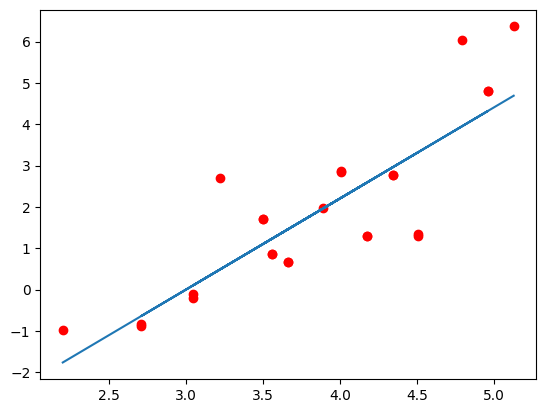

In [89]:
plt.plot(np.log(prime_times[0]), np.log(prime_times[1]), "ro")
plt.plot(np.log(prime_times[0]), np.log(prime_times[0]) * power + np.log(coeff))

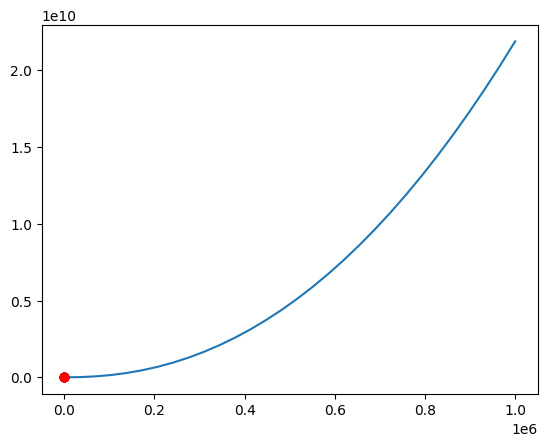

In [91]:
sample_space = np.linspace(1, 1e6, 30)
plt.plot(sample_space, coeff * np.power(sample_space, power))
plt.plot(prime_times[0], prime_times[1], "ro")

In [ ]:
test_primes = [3, 5, 7, 11, 13]
quantum_times = dict()
init_times = dict()

for p1 in test_primes:
    for p2 in test_primes:
        if p1 * p2 > 100:
            continue
        print(f"Timing {p1}, {p2}")
        start_time = time.time()

        semiprime = p1 * p2 
        base = 8 
        circuit_size = np.ceil(np.log2(semiprime)).astype(int)

        aux = QuantumRegister(circuit_size+2)
        up_reg = QuantumRegister(2*circuit_size)
        down_reg = QuantumRegister(circuit_size)
        up_classic = ClassicalRegister(2*circuit_size)
        circuit = QuantumCircuit(down_reg, up_reg, aux, up_classic)

        #Initialize down register to 1 and create maximal superposition in top register
        circuit.h(up_reg)
        circuit.x(down_reg[0])

        for i in range(0, 2*circuit_size):
            cMULTmodN(circuit, up_reg[i], down_reg, aux, int(pow(base, pow(2, i))), semiprime, circuit_size)

        create_inverse_QFT(circuit, up_reg, 2 * circuit_size, 1)
        circuit.measure(up_reg,up_classic)
        
        init_times[(p1, p2)]

        qr_backend = QrBackendV2(qr_provider, num_qubits = circuit.num_qubits)
        qc_transpiled = transpile(circuit, qr_backend, initial_layout=[i for i in range(0, circuit.num_qubits)])

        job = qr_backend.run(qc_transpiled, shots = shots)
        result = job.result()
        counts = result.get_counts()
        
        quantum_times[(p1, p2)] = time.time() - start_time